<a href="https://colab.research.google.com/github/sumanapalle065/LC25000-Hybrid-Architecture-using-DL/blob/model-training/LC25000_Hybrid_Arc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
import cv2
import numpy as np
import os
import glob # library to retrieve file paths matching a pattern
import matplotlib.pyplot as matplib # library for plotting graphs
import random # Random library for random number generation
from PIL import Image, ImageEnhance
from tqdm import tqdm # import TQDM library for displaying progress bars within loops
from skimage.color import rgb2lab, lab2rgb
import tensorflow as tf
from tensorflow.keras import layers, models, backend as K
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score # Sklearn metrics for classification performance
import seaborn as sns
from sklearn.metrics import confusion_matrix
import itertools
from sklearn.preprocessing import label_binarize # Funciton for converting labels to binary format for multiclass problems
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.utils import to_categorical

In [18]:
# !unzip "/content/drive/MyDrive/LC25000.zip"

In [5]:
# In the lung_colon_image_set directory and its subdirectories, use glob to retrieve all image file paths.
lung_colon_image_set_df=glob.glob("/content/lung_colon_image_set/*/*/*")

In [6]:
lung_colon_image_set_df

['/content/lung_colon_image_set/colon_image_sets/colon_n/colonn583.jpeg',
 '/content/lung_colon_image_set/colon_image_sets/colon_n/colonn2257.jpeg',
 '/content/lung_colon_image_set/colon_image_sets/colon_n/colonn4927.jpeg',
 '/content/lung_colon_image_set/colon_image_sets/colon_n/colonn476.jpeg',
 '/content/lung_colon_image_set/colon_image_sets/colon_n/colonn2862.jpeg',
 '/content/lung_colon_image_set/colon_image_sets/colon_n/colonn2056.jpeg',
 '/content/lung_colon_image_set/colon_image_sets/colon_n/colonn2894.jpeg',
 '/content/lung_colon_image_set/colon_image_sets/colon_n/colonn871.jpeg',
 '/content/lung_colon_image_set/colon_image_sets/colon_n/colonn4534.jpeg',
 '/content/lung_colon_image_set/colon_image_sets/colon_n/colonn2023.jpeg',
 '/content/lung_colon_image_set/colon_image_sets/colon_n/colonn2468.jpeg',
 '/content/lung_colon_image_set/colon_image_sets/colon_n/colonn1794.jpeg',
 '/content/lung_colon_image_set/colon_image_sets/colon_n/colonn4141.jpeg',
 '/content/lung_colon_image_

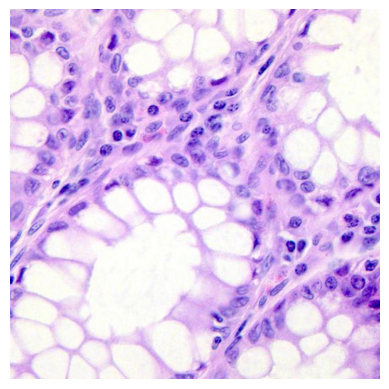

In [7]:
# Choose a randomly selected image path from
image_path = random.choice(lung_colon_image_set_df)  # Choosen a randomly selected image path from the dataset
image = cv2.imread(image_path)
# Change the color space of the image from BGR color space to RGB color space since we know OpenCV reads in images by default in BGR
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# Display the image using Matplotlib
matplib.imshow(image)  # Displays the image on the plot
matplib.axis('off')  # Hides the axes for a cleaner view of the image
matplib.show()  # Shows the plot with the image

100%|██████████| 25000/25000 [01:11<00:00, 351.38it/s]


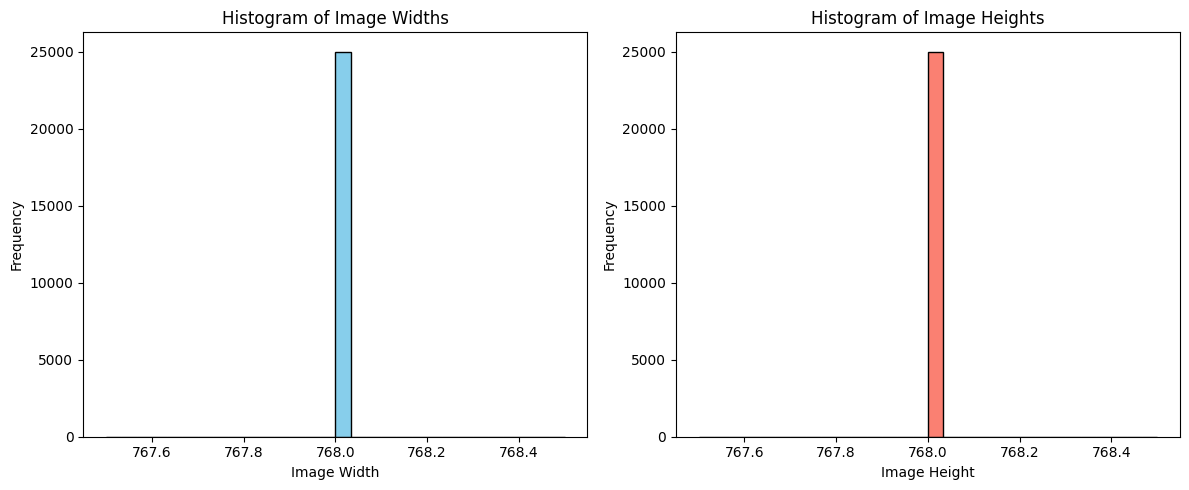

<ipython-input-8-076f67684bc8>:43: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x='Width', y='Height', data=df, hue=None, palette='viridis')


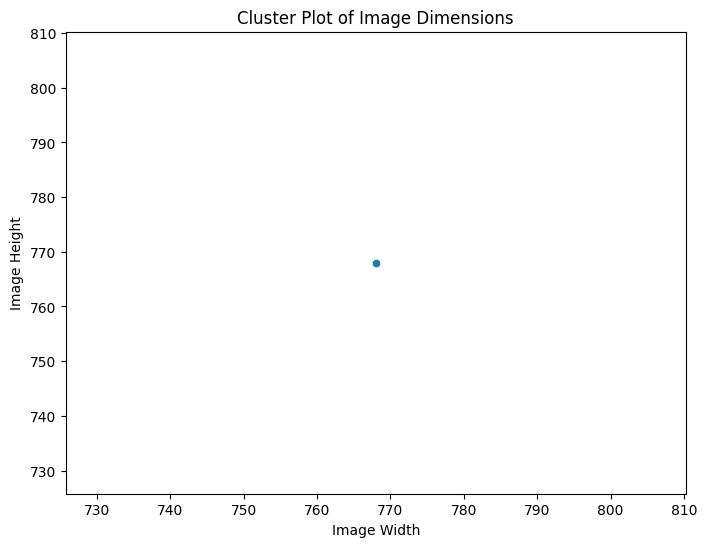

In [8]:
import matplotlib.pyplot as plt

# Initializing lists to store image widths and heights
widths = []
heights = []

# Loop through each image path in the dataset
for img_path in tqdm(lung_colon_image_set_df):
    img = cv2.imread(image_path)
    if img is not None:
        h, w = img.shape[:2]  # Get image height and width
        heights.append(h)
        widths.append(w)

# Plot the histograms for widths and heights
plt.figure(figsize=(12, 5))

# Width Histogram
plt.subplot(1, 2, 1)
plt.hist(widths, bins=30, color='skyblue', edgecolor='black')
plt.xlabel("Image Width")
plt.ylabel("Frequency")
plt.title("Histogram of Image Widths")

# Height Histogram
plt.subplot(1, 2, 2)
plt.hist(heights, bins=30, color='salmon', edgecolor='black')
plt.xlabel("Image Height")
plt.ylabel("Frequency")
plt.title("Histogram of Image Heights")

plt.tight_layout()
plt.show()

# Cluster Plot for Widths and Heights
import pandas as pd

# Convert the data to a DataFrame for easy plotting
df = pd.DataFrame({'Width': widths, 'Height': heights})

# Plot a cluster plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Width', y='Height', data=df, hue=None, palette='viridis')
plt.xlabel("Image Width")
plt.ylabel("Image Height")
plt.title("Cluster Plot of Image Dimensions")
plt.show()


In [9]:
# Suppress warnings to prevent useless output in the console
import warnings
warnings.filterwarnings("ignore")

# Function for simple stain normalization without PCA
def simple_stain_normalization(img, target_img, alpha=1):
    # Convert both images from RGB to LAB color space (LAB is better for color manipulation)
    img_lab = rgb2lab(img)  # Convert the input image to LAB color space
    target_lab = rgb2lab(target_img)  # Convert the target image to LAB color space

    # Compute the mean and standard deviation of the LAB channels for both images
    img_mean = np.mean(img_lab, axis=(0, 1), keepdims=True)  # Mean across the height and width (per channel)
    img_std = np.std(img_lab, axis=(0, 1), keepdims=True)  # Standard deviation across the height and width (per channel)
    target_mean = np.mean(target_lab, axis=(0, 1), keepdims=True)  # Mean of the target image (per channel)
    target_std = np.std(target_lab, axis=(0, 1), keepdims=True)  # Standard deviation of the target image (per channel)

   # Normalize the input image based on the mean and std of the target image
    img_normalized = (img_lab - img_mean) / img_std * target_std + target_mean  # Adjust to match the target image's color stats

    # Transpose the normalized image from LAB back to RGB
    img_rgb_normalized = lab2rgb(img_normalized)  # Convert back to RGB color space

    # Return the normalized image (scaled back to 0-255 range)
    return (img_rgb_normalized * 255).astype(np.uint8)

# Lists to hold the processed images and their corresponding labels
processed_images = []  # List to hold the processed images
labels = []  # List to hold the labels corresponding to each image

# Define a label map to associate image categories with numerical labels
label_map = {
    "lung_aca": 0,  # Adenocarcinoma of the lung
    "colon_n": 1,  # Normal colon tissue
    "lung_n": 2,  # Normal lung tissue
    "lung_scc": 3,  # Squamous cell carcinoma of the lung
    "colon_aca": 4,  # Adenocarcinoma of the colon
}

# Path to a target image (used for stain normalization)
target_img_path = '/content/lung_colon_image_set/colon_image_sets/colon_aca/colonca4273.jpeg'
target_img = cv2.imread(target_img_path)  # Read the target image from disk
target_img = cv2.resize(target_img, (224, 224))  # Resize the target image to 224x224 pixels

# Iterate over each image in the dataset (from lung_colon_image_set_df)
for img_path in tqdm(lung_colon_image_set_df):
    img = cv2.imread(img_path)  # Read the image from the specified path
    if img is None:  # Skip if the image couldn't be loaded (i.e., it's None)
        continue

    img = cv2.resize(img, (128, 128))  # Resize the image to match the target image size (224x224)

   # Use the stain normalization function to the image with the target image
    img = simple_stain_normalization(img, target_img)

    # Append the normalized image to list of normalized images
    processed_images.append(img)

    # Extract the label of the image from the folder name
    label = img_path.split(os.path.sep)[-2]  # Get the parent folder (label) from the image path
    if label in label_map:  # If the label is in the predefined map
        labels.append(label_map[label])  # Append the numerical label to the labels list

# Convert the lists of processed images and labels to NumPy arrays
processed_images = np.array(processed_images)  # Array of processed images
labels = np.array(labels)  # Array of labels

# Print the completion message with the total number of processed images
print("Preprocessing complete. Total processed images:", len(processed_images))


100%|██████████| 25000/25000 [07:33<00:00, 55.14it/s]


Preprocessing complete. Total processed images: 25000


In [10]:
# Convert processed_images to a NumPy array
processed_images_array = np.array(processed_images)

# Convert Labels to a NumPy array
labels_array = np.array(labels)

# Print the shapes of the arrays to verify they are NumPy arrays
print("Shape of processed_images_array:", processed_images_array.shape)
print("Shape of labels_array:", labels_array.shape)

Shape of processed_images_array: (25000, 128, 128, 3)
Shape of labels_array: (25000,)


In [11]:
from sklearn.model_selection import train_test_split
# Split the lung_colon_image_set_df into training and testing sets (80% train, 20% test)
Xtrain_lung_colon_image_set_df, Xtest_lung_colon_image_set_df, ytrain_lung_colon_image_set_df, ytest_lung_colon_image_set_df = train_test_split(
    processed_images_array, labels_array, test_size=0.2, random_state=100
)

In [12]:
#Print the shape of the trainning images
print("X_train shape:", Xtrain_lung_colon_image_set_df.shape)  # Prints the shape of the training image data (features)
# Print the shape of the testing images
print("X_test shape:", Xtest_lung_colon_image_set_df.shape)  # Prints the shape of the testing image data (features)

# Print the shape of the trainning labels
print("y_train shape:", ytrain_lung_colon_image_set_df.shape)  # Prints the shape of the training labels (targets)

# Print the shape of the testing labels
print("y_test shape:", ytest_lung_colon_image_set_df.shape)  # Prints the shape of the testing labels (targets)


X_train shape: (20000, 128, 128, 3)
X_test shape: (5000, 128, 128, 3)
y_train shape: (20000,)
y_test shape: (5000,)


In [13]:

ytrain_lung_colon_image_set_df= to_categorical(ytrain_lung_colon_image_set_df, num_classes=5)
ytest_lung_colon_image_set_df = to_categorical(ytest_lung_colon_image_set_df, num_classes=5)

In [14]:
# Print the shape of the training labels
print("y_train shape:", ytrain_lung_colon_image_set_df.shape) # Prints the shape of the training labels (targets)

# Print the shape of the testing labels
print("y_test shape:", ytest_lung_colon_image_set_df.shape) # Prints the shape of the testing labels (targets)

y_train shape: (20000, 5)
y_test shape: (5000, 5)


In [15]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [16]:

# Lambda function for grafting GLPP features
def graft_glpp_features(cnn_features, glpp_features):
    # Concatenate automated CNN features and handcrafted GLPP features
    return K.concatenate([cnn_features, glpp_features], axis=-1)

# Define the custom feature grafting layer
class GLPPLayer(layers.Layer):
    def __init__(self):
        super(GLPPLayer, self).__init__()

    def call(self, cnn_features, glpp_features):
        return graft_glpp_features(cnn_features, glpp_features)

# Define the ColonNet model
def ColonNet(input_shape=(128, 128, 3), num_classes=5, glpp_feature_size=100):
    # Input for image
    input_image = layers.Input(shape=input_shape, name="Image_Input")

    # Pretrained base model (InceptionV3) for feature extraction
    base_model = InceptionV3(include_top=False, weights="imagenet", input_tensor=input_image)
    base_model.trainable = False  # Freeze the base model layers

    # Automated CNN feature extraction
    cnn_features = layers.GlobalAveragePooling2D()(base_model.output)

    # Input for manually extracted GLPP features
    input_glpp = layers.Input(shape=(glpp_feature_size,), name="GLPP_Input")

    # Graft the GLPP features into the network (manual + automated features)
    grafted_features = GLPPLayer()(cnn_features, input_glpp)

    # Fully connected layers after feature fusion
    x = layers.Dense(1020, activation="relu")(grafted_features)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(1020, activation="relu")(x)
    x = layers.Dropout(0.5)(x)

    # Output layer (Softmax for multi-class classification)
    output = layers.Dense(num_classes, activation="softmax", name="Output")(x)

    # Define the final model
    model = models.Model(inputs=[input_image, input_glpp], outputs=output, name="ColonNet")

    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss="categorical_crossentropy", metrics=["accuracy"])

    return model
# Example usage:
input_shape = (128, 128, 3)
num_classes = 5  #  5 classes (lung and colon cancer types)
glpp_feature_size = 100  # Size of GLPP feature vector

# Create ColonNet model
colonnet_model = ColonNet(input_shape=input_shape, num_classes=num_classes, glpp_feature_size=glpp_feature_size)

# Print the model summary
colonnet_model.summary()


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "ColonNet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Image_Input (InputLayer)  │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 63, 63, 32)     │            864 │ Image_Input[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 63, 63, 32)     │             96 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 63, 63, 32)     │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 61, 61, 32)     │          9,216 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 61, 61, 32)     │             96 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 61, 61, 32)     │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 61, 61, 64)     │         18,432 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 61, 61, 64)     │            192 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 61, 61, 64)     │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 30, 30, 64)     │              0 │ activation_2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 30, 30, 80)     │          5,120 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 30, 30, 80)     │            240 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 30, 30, 80)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 28, 28, 192)    │        138,240 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 28, 28, 192)    │            576 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_4 (Activat

 Total params: 25,041,289 (95.52 MB)

 Trainable params: 3,238,505 (12.35 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [17]:
glpp_train = np.random.rand(Xtrain_lung_colon_image_set_df.shape[0], 100)  # Generating Training Features (100 features for each sample randomly)
glpp_test = np.random.rand(Xtest_lung_colon_image_set_df.shape[0], 100)    # Generating Test Features (100 features for each sample randomly)

history = colonnet_model.fit(   # Fitting a ColonNet Model
    x=[Xtrain_lung_colon_image_set_df, glpp_train],  # Input to the model: Image data and the random features for training
    y=ytrain_lung_colon_image_set_df,  # Labels for training
    epochs = 250,
    batch_size = 232,
    validation_data = ([Xtest_lung_colon_image_set_df, glpp_test], ytest_lung_colon_image_set_df),  # Validation data: Now a list with image data and GLPP features
)
#history = colonnet_model.fit(   # Fitting a ColonNet Model
 #   x=[Xtrain_lung_colon_image_set_df, glpp_train],  # Input to the model: Image data and the random features for training
  #  y=ytrain_lung_colon_image_set_df,  # Labels for training
#epochs = 250,
#batch_size = 232,
#validation_data = (Xtest_lung_colon_image_set_df, glpp_test),  # Validation data. NO. see below
#)


Epoch 1/250
87/87 ━━━━━━━━━━━━━━━━━━━━ 54s 372ms/step - accuracy: 0.2819 - loss: 51.9931 - val_accuracy: 0.4742 - val_loss: 1.4262
Epoch 2/250
87/87 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.3516 - loss: 1.8670 - val_accuracy: 0.4584 - val_loss: 1.3316
Epoch 3/250
87/87 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.3668 - loss: 1.5384 - val_accuracy: 0.4830 - val_loss: 1.3151
Epoch 4/250
87/87 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.3785 - loss: 1.4626 - val_accuracy: 0.4844 - val_loss: 1.2644
Epoch 5/250
87/87 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.4025 - loss: 1.4157 - val_accuracy: 0.5078 - val_loss: 1.2017
Epoch 6/250
87/87 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.4077 - loss: 1.3789 - val_accuracy: 0.5028 - val_loss: 1.2320
Epoch 7/250
87/87 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - accuracy: 0.4217 - loss: 1.3694 - val_accuracy: 0.5114 - val_loss: 1.1707
Epoch 8/250
87/87 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - accuracy: 0.4198 - loss: 1.3753 - val_accuracy: